In [1]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from netrep.metrics import LinearMetric, GaussianStochasticMetric

# My code. 
import generators

# The parameters I ran the experiment with. 
PROMPT = "A long time ago"
PROMPT_LENGTH = len(PROMPT.split(" "))
SEEDS = [100, 400, 900]
TEMPERATURES = [1, 1.5]
NUM_EXPERIMENTS = 800
NUM_TOKENS = 20


# Of shape (Temperature, Seed, Num_Experiments, Num_Classes, 64)
per_trial_data = np.load('data/1M_experiment800N_2TEMP_per_trial_tensor.npy')

# per_trial_data_promptB = np.load('ranging_temperature_across_k_seeds/1M_experiment800N_1TEMP_PROMPTB_per_trial_tensor.npy')
# per_trial_data[0] = per_trial_data_promptB[1]

per_trial_data.shape

/opt/anaconda3/envs/lipshutz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(2, 3, 800, 23, 64)

In [120]:
# Take the average over the number of experiments. 
mean_trajectories = np.mean(per_trial_data, 2)
print(mean_trajectories.shape)

# Then reshape the trajectories into (Variables, Time points, Neurons)
reshaped = mean_trajectories.reshape(len(TEMPERATURES) * len(SEEDS), PROMPT_LENGTH + NUM_TOKENS - 1, 64)

# Array of [ (Time points, Neurons), ... ]
Xs = []
for i in range(reshaped.shape[0]):
    Xs.append(reshaped[i,:, :])

print(reshaped.shape)
print(len(Xs))
print(Xs[0].shape)

(2, 3, 23, 64)
(6, 23, 64)
6
(23, 64)


In [ ]:

# ### AVERAGE OVER N TRIALS
# mean_test = np.mean(per_trial_data, 2)
# mean_test = mean_test.reshape((6, 23, 64))


# X = []

# for i in range(6):
#     X.append(mean_test[i,:, :])
# #     # Y.append(t2[i, :, -10:])

### AVERAGE OVER THE TOKENS
# mean_test = np.mean(per_trial_data, 3)
# mean_test = mean_test.reshape((6, 800, 64))

# X = []
# for i in range(6):
#     X.append(mean_test[i,:, :])
# #     # Y.append(t2[i, :, -10:])

### AVERAGE OVER THE SEEDS
# mean_test = np.mean(per_trial_data, 1)
# t1 = mean_test[1] # 

# X = []

# for i in range(25):
#     X.append(t1[i, :, :])
#     X.append(t1[i, :, :])
#     # Y.append(t2[i, :, -10:])


# split_data = [np.array_split(x, 2) for x in Xs]
# # print(X[0].shape)
# X_train = [x for (x, _) in split_data ]
# X_test = [x for (_, x) in split_data]

# metric = LinearMetric(alpha=1)
# train_dist, test_dist = metric.pairwise_distances(X_train, X_test)



Parallelizing 15 distance calculations with 8 processes.


Computing distances: 100%|██████████| 15/15 [00:02<00:00,  5.55it/s]


In [ ]:
### LINEAR PROCRUSTES DISTANCE ###

split_data = [np.array_split(x, 2) for x in Xs]
X_train = [x for (x, _) in split_data ]
X_test = [x for (_, x) in split_data]

alphas = [0, 0.5, 1] # alphas to use for linear metric
linear_distances = [] # array of distances

print(f"len(Xs)={len(Xs)}")
print(f"len(X_train)={len(X_train)}")
print(f"len(X_test)={len(X_test)}")


for alpha in alphas:
    metric = LinearMetric(alpha=alpha)
    train_dist, test_dist = metric.pairwise_distances(X_train, X_test)  
    linear_distances.append(test_dist)

print(np.max(linear_distances))

len(Xs)=6
len(X_train)=6
len(X_test)=6
[array([[ 9.45894746e-04,  1.65509749e-02,  8.91832821e-03,
         2.92777307e-02,  2.56587863e-02, -9.14655626e-04,
        -9.66902636e-03, -1.05579337e-02, -2.06135698e-02,
        -8.05688873e-02, -2.32127924e-02, -3.29969935e-02,
        -9.56499577e-03,  2.23492905e-02,  4.72296309e-03,
        -3.24695837e-04, -4.01536301e-02, -1.16407499e-03,
         6.80627674e-03, -3.17438468e-02,  3.59148122e-02,
         1.46375978e-02, -2.60588303e-02,  4.30669561e-02,
         4.49138228e-03,  4.89530638e-02,  2.83696037e-02,
        -2.16803141e-02, -2.28654873e-02, -2.32286248e-02,
         3.08452500e-03,  7.63848796e-03, -3.41219380e-02,
         3.04621290e-02, -3.30214202e-03, -1.63947791e-02,
         5.47463410e-02, -1.66336335e-02, -3.78751680e-02,
        -2.65862830e-02, -1.00096595e-03, -4.21584072e-03,
         2.16999184e-02, -3.99131514e-03,  1.72243454e-02,
        -6.14741538e-03, -2.34874338e-03,  7.20765144e-02,
         3.44109

In [ ]:
### CALCULATES STOCHASTIC SHAPE DISTANCE ###
### DONT FIGURE TO REDUCE FEATURES FROM 64 to 10 ### 
import random

gaussian_distances = []

def cov3d(data):
    '''
    Calculates the covariance for a 3D array.
    Iterates over L (some number of parameters or samples) and calculates the covariance.
    '''
    if(len(data.shape) != 3):
        print("ERROR NOT 3D")
        return None

    L, N, M = data.shape
    covar_matrices = np.zeros((L, M, M))
    for i in range(L):
        covar_matrices[i] = np.cov(data[i, :, :], rowvar=False)
    
    return covar_matrices


# First do PCA bc covariance on 64 features takes a long time
reshaped_per_trial_data = per_trial_data.reshape(((len(TEMPERATURES)* len(SEEDS), NUM_EXPERIMENTS, PROMPT_LENGTH + NUM_TOKENS - 1, 64) ))
pca_per_trial_data = np.empty((len(TEMPERATURES)*len(SEEDS), NUM_EXPERIMENTS, PROMPT_LENGTH + NUM_TOKENS - 1, 10))
print(pca_per_trial_data.shape)

pca = PCA(n_components=10)
for i in range(reshaped_per_trial_data.shape[0]):
    for n in range(NUM_EXPERIMENTS):
        pca.fit(reshaped_per_trial_data[i, n])
        pca_data = pca.transform(reshaped_per_trial_data[i,n])
        pca_per_trial_data[i, n] = pca_data


# Get mean over 800. 
pca_mean_trajectory = np.mean(pca_per_trial_data, 1)
print(pca_mean_trajectory.shape)

# Get Cov over N experiemnts and create input array
Xz = [] # gaussian input

# input to GSM is (23, 10) and cov needs to be (23, 10, 10)
reshaped_for_covariance = pca_per_trial_data.reshape( (pca_per_trial_data.shape[0], pca_per_trial_data.shape[2], 
                                                       pca_per_trial_data.shape[1], pca_per_trial_data.shape[3]))
for i in range(reshaped_for_covariance.shape[0]):
    covar = cov3d(reshaped_for_covariance[i])
    Xz.append((pca_mean_trajectory[i], covar))


X_train = Xz[:3]
# X_test = Xz[1:]
print(len(Xz))
print(len(X_test))

alphas = [0, 1, 2] # 0 only uses covar, 1 = 2-Wasserstein, 2 = only uses means
for alpha in alphas:
    metric = GaussianStochasticMetric(alpha=alpha, init='rand', n_restarts=50)
    train_dist, test_dist = metric.pairwise_distances(X_train, Xz)
    gaussian_distances.append(test_dist)


(6, 800, 23, 10)
(6, 23, 10)
6
5
Parallelizing 3 distance calculations with 8 processes.


Computing distances: 100%|██████████| 3/3 [01:20<00:00, 26.92s/it]

Parallelizing 3 distance calculations with 8 processes.



Computing distances: 100%|██████████| 3/3 [00:41<00:00, 13.78s/it]

Parallelizing 3 distance calculations with 8 processes.



Computing distances: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


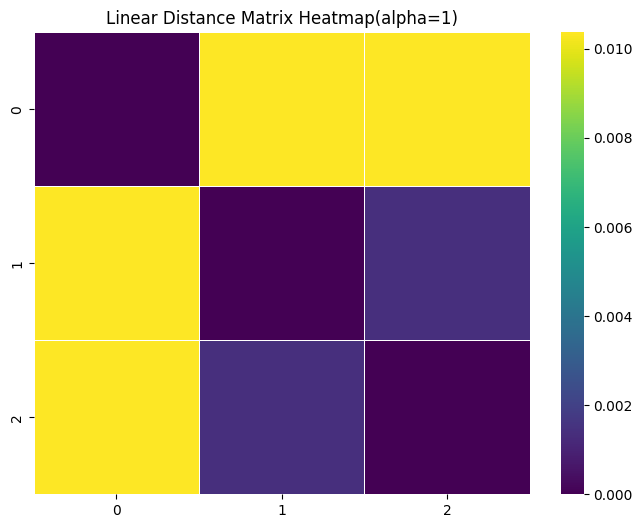

In [142]:

# font = {'size': 10}
# plt.rc('font', **font)

plt.figure(figsize=(8, 6)) # Adjust figure size as needed
sns.heatmap(gaussian_distances[0], cmap='viridis', annot=False, fmt=".2f", linewidths=.5)

plt.title('Linear Distance Matrix Heatmap(alpha=1)')
plt.show()